In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# IRIS

In [49]:
geo_iris = gpd.read_file("../data/processed/44055/iris/demand_per_hab.geojson")
geo_iris

,code_iris,nom_iris,revenues,population,density_km2,demand_pop_kWh,geometry
0,440550101,La Baule les Pins,31760,2346.994576,1290.289305,463.191521,"MULTIPOLYGON (((-2.35133 47.27244, -2.35149 47..."
1,440550102,Centre-Benoît,31940,1616.919056,1029.639154,321.254665,"MULTIPOLYGON (((-2.38127 47.27993, -2.38559 47..."
2,440550103,Gare-Grand Clos,26750,1869.032071,1584.310324,317.430572,"MULTIPOLYGON (((-2.4273 47.27833, -2.42724 47...."
3,440550104,Beslon,23160,2408.488869,1057.621831,206.515939,"MULTIPOLYGON (((-2.40491 47.28723, -2.40464 47..."
4,440550105,Escoublac,27110,3511.317978,421.501327,218.825894,"MULTIPOLYGON (((-2.38977 47.30009, -2.38918 47..."
5,440550106,Le Guézy,27800,4467.253898,394.213733,282.994680,"MULTIPOLYGON (((-2.29702 47.3032, -2.2972 47.3..."


In [50]:
locations = geo_iris.index.to_list()

demands_kWh = geo_iris["demand_pop_kWh"].to_list()
demands_pop = geo_iris["population"].to_list()

prices_kWh = [0.25] * len(locations)
prices_pop = [20] * len(locations)

costs = [60000 / (365 * 15)] * len(locations)

station_capacity_kWh = 22 * 12 # 22kW * 12h
station_capacity_pop = 1e6 / geo_iris["density_km2"].mean()

max_distance = 1
max_total_stations = 10
existing_stations = None
existing_station_capacity = None
max_stations_per_location = 5

# Adjacency matrix
adjacency = np.load("../data/processed/44055/iris/adjacency_matrix.npy")

# Genetic parameters
population_size = 100
mutation_rate = 0.2
crossover_rate = 0.8
elite_size = 10
max_generations = 100

In [51]:
from GA import ChargingStationGA

simulation_type = "kWh"  # ou "kWh"

for simulation_type in ["kWh", "pop"]:
    for max_total_stations in [1, 5, 10, 20]:
        # Genetic algorithm
        ga = ChargingStationGA(
            locations,
            demands_pop if simulation_type == "pop" else demands_kWh,
            prices_pop if simulation_type == "pop" else prices_kWh,
            costs,
            max_distance,
            station_capacity_pop if simulation_type == "pop" else station_capacity_kWh,
            max_total_stations,
            existing_stations,
            existing_station_capacity,
            max_stations_per_location,
            population_size,
            mutation_rate,
            crossover_rate,
            elite_size,
            max_generations,
            adjacency,
        )
        solution_iris, stats_iris = ga.run()

        demand_unit = "pop" if simulation_type == "pop" else "kWh"


        # Enregistrement des résultats
        results = {
            "zone": "iris",
            "demand": demand_unit,
            "solution": solution_iris.tolist(),
            "profit": stats_iris["profit"],
            "demand_satisfaction": stats_iris["demand_satisfaction"],
            "parameters": {
                "population_size": population_size,
                "mutation_rate": mutation_rate,
                "crossover_rate": crossover_rate,
                "elite_size": elite_size,
                "max_generations": max_generations,
                "max_distance": max_distance,
                "station_capacity_kWh": station_capacity_kWh,
                "station_capacity_pop": station_capacity_pop,  # Ajout si pertinent
                "max_total_stations": max_total_stations,
                "max_stations_per_location": max_stations_per_location,
            },
        }
        total_demand_satisfied = sum(solution_iris) * (station_capacity_kWh if simulation_type == "kWh" else station_capacity_pop)
        results["profit"] = total_demand_satisfied * (0.25 if simulation_type == "kWh" else 20) - 60000 / (365 * 15)

        # Enregistrement des résultats
        import json

        # Nom du fichier dépendant du type de simulation
        filename = f"results/iris/results_{results['zone']}_{simulation_type}_{results['parameters']['max_total_stations']}.json"

        # Sauvegarde dans un fichier JSON
        with open(filename, "w") as f:
            json.dump(results, f, indent=4)


Starting genetic algorithm optimization...
Station capacity: 264 kWh/day
Maximum total stations: 1
Generation 0: Fitness = 90.32, Profit: 55.04, Coverage: 35.28, Avg Satisfaction: 83.2%, Stations: 1
Generation 10: Fitness = 90.32, Profit: 55.04, Coverage: 35.28, Avg Satisfaction: 83.2%, Stations: 1
Generation 20: Fitness = 90.32, Profit: 55.04, Coverage: 35.28, Avg Satisfaction: 83.2%, Stations: 1
Generation 30: Fitness = 90.32, Profit: 55.04, Coverage: 35.28, Avg Satisfaction: 83.2%, Stations: 1
Generation 40: Fitness = 90.32, Profit: 55.04, Coverage: 35.28, Avg Satisfaction: 83.2%, Stations: 1
Generation 50: Fitness = 90.32, Profit: 55.04, Coverage: 35.28, Avg Satisfaction: 83.2%, Stations: 1
Generation 60: Fitness = 90.32, Profit: 55.04, Coverage: 35.28, Avg Satisfaction: 83.2%, Stations: 1
Generation 70: Fitness = 90.32, Profit: 55.04, Coverage: 35.28, Avg Satisfaction: 83.2%, Stations: 1
Generation 80: Fitness = 90.32, Profit: 55.04, Coverage: 35.28, Avg Satisfaction: 83.2%, Stati

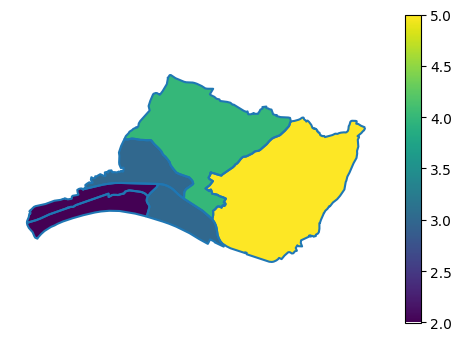

In [42]:
geo_iris["solution"] = solution_iris

fig, ax = plt.subplots(figsize=(6, 4))
geo_iris.boundary.plot(ax=ax)
geo_iris.plot(column='solution', ax=ax, legend=True)
ax.set_axis_off()
plt.show()

# 1km

In [43]:
geo_1km = gpd.read_file("../data/processed/44055/1km/gdf_city_with_dist.gpkg")
geo_1km.head()

,id,population,density_km2,niveau_de_vie_moyen,demand_pop_kWh,demand_traffic_kWh,total_demand_kWh,concu_nb_pdc,vinci_nb_pdc,nb_pdc,...,dist_36,dist_37,dist_38,dist_39,dist_40,dist_41,dist_42,dist_43,dist_44,geometry
0,CRS3035RES1000mN2761000E3390000,355.0,355.614191,29963.222254,48.172830,0.000000,48.172830,0.0,0.0,0.0,...,5.004289,5.665575,6.415565,5.363373,5.079982,4.985151,5.089426,6.060643,5.982180,"POLYGON ((-2.35724 47.26121, -2.35937 47.27007..."
1,CRS3035RES1000mN2761000E3391000,2108.0,2111.645642,27232.834250,204.580618,0.000000,204.580618,0.0,12.0,12.0,...,4.471250,5.004286,5.665562,5.807820,5.363407,5.080016,4.985181,6.299356,6.060683,"POLYGON ((-2.34418 47.26271, -2.34631 47.27156..."
2,CRS3035RES1000mN2761000E3392000,115.0,115.198806,27779.578261,0.439140,0.139226,0.578365,0.0,0.0,0.0,...,4.116594,4.471257,5.004283,6.379721,5.807851,5.363441,5.080050,6.681128,6.299397,"POLYGON ((-2.33112 47.2642, -2.33325 47.27306,..."
3,CRS3035RES1000mN2761000E3393000,58.0,58.100227,26093.732759,0.000000,0.904665,0.904665,0.0,0.0,0.0,...,3.988194,4.116611,4.471264,7.048117,6.379747,5.807882,5.363474,7.183185,6.681168,"POLYGON ((-2.31807 47.26569, -2.32019 47.27455..."
4,CRS3035RES1000mN2762000E3389000,271.0,271.467944,33466.048708,32.093207,0.000000,32.093207,4.0,0.0,4.0,...,5.010184,5.844076,6.723794,4.107195,3.988095,4.116531,4.471217,4.985118,5.089390,"POLYGON ((-2.37243 47.26857, -2.37456 47.27743..."


In [44]:
# Parameters
locations = geo_1km.index.to_list()

demands_kWh = geo_1km["demand_pop_kWh"].to_list()
demands_pop = geo_1km["population"].to_list()

prices_kWh = [0.25] * len(locations)
prices_pop = [20] * len(locations)

costs = [60000 / (365 * 15)] * len(locations)

station_capacity_kWh = 22 * 12 # 60kW * 8h
station_capacity_pop = 1e6 / geo_1km["density_km2"].mean()

max_distance = 1
max_total_stations = 10
existing_stations = None
existing_station_capacity = None
max_stations_per_location = 5

# Adjacency matrix
adjacency = np.load("../data/processed/44055/1km/adjacency_matrix.npy")

# Genetic parameters
population_size = 100
mutation_rate = 0.2
crossover_rate = 0.8
elite_size = 10
max_generations = 100

In [45]:

for simulation_type in ["kWh", "pop"]:
    for max_total_stations in [1, 5, 10, 20]:

        ga_1km = ChargingStationGA(
            locations,
            demands_pop if simulation_type == "pop" else demands_kWh,
            prices_pop if simulation_type == "pop" else prices_kWh,
            costs,
            max_distance,
            station_capacity_pop if simulation_type == "pop" else station_capacity_kWh,
            max_total_stations,
            existing_stations,
            existing_station_capacity,
            max_stations_per_location,
            population_size,
            mutation_rate,
            crossover_rate,
            elite_size,
            max_generations,
            adjacency,
        )
        solution_1km, stats_1km = ga_1km.run()


        demand_unit = "pop" if simulation_type == "pop" else "kWh"


        # Enregistrement des résultats
        results = {
            "zone": "1km",
            "demand": demand_unit,
            "solution": solution_1km.tolist(),
            "solution": solution_1km.tolist(),
            "profit": stats_1km["profit"],
            "demand_satisfaction": stats_1km["demand_satisfaction"],
            "parameters": {
                "population_size": population_size,
                "mutation_rate": mutation_rate,
                "crossover_rate": crossover_rate,
                "elite_size": elite_size,
                "max_generations": max_generations,
                "max_distance": max_distance,
                "station_capacity_kWh": station_capacity_kWh,
                "station_capacity_pop": station_capacity_pop,
                "max_total_stations": max_total_stations,
                "max_stations_per_location": max_stations_per_location,
            },
        }

        total_demand_satisfied = sum(solution_1km) * (station_capacity_kWh if simulation_type == "kWh" else station_capacity_pop)
        results["profit"] = total_demand_satisfied * (0.25 if simulation_type == "kWh" else 20) - 60000 / (365 * 15)

        # Enregistrement des résultats
        import json

        # Nom du fichier dépendant du type de simulation
        filename = f"results/1km/results_{results['zone']}_{simulation_type}_{results['parameters']['max_total_stations']}.json"

        # Sauvegarde dans un fichier JSON
        with open(filename, "w") as f:
            json.dump(results, f, indent=4)

Starting genetic algorithm optimization...
Station capacity: 264 kWh/day
Maximum total stations: 1
Generation 0: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1
Generation 10: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1
Generation 20: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1
Generation 30: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1
Generation 40: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1


/Users/maximemoutet/Documents/Scolaire/M2DS/Capstone/capstone-vinci/model/GA.py:184: RuntimeWarning: divide by zero encountered in divide
  satisfaction_percentage = min(1.0, total_capacity / location_demand)


Generation 50: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1
Generation 60: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1
Generation 70: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1
Generation 80: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1
Generation 90: Fitness = 65.47, Profit: 47.69, Coverage: 17.78, Avg Satisfaction: 100.0%, Stations: 1

Optimization complete after 100 generations
Best solution fitness: 65.47
Best profit: 47.69
Total demand satisfied: 13.29%
Best coverage: 17.78
Total stations: 1
Average demand satisfaction at active locations: 100.0%
Starting genetic algorithm optimization...
Station capacity: 264 kWh/day
Maximum total stations: 5
Generation 0: Fitness = 129.32, Profit: 74.90, Coverage: 54.42, Avg Satisfaction: 100.0%, Stations: 5
Generation 10: Fitness = 229.20, Profit: 155.35, Coverage: 73.85, Avg 

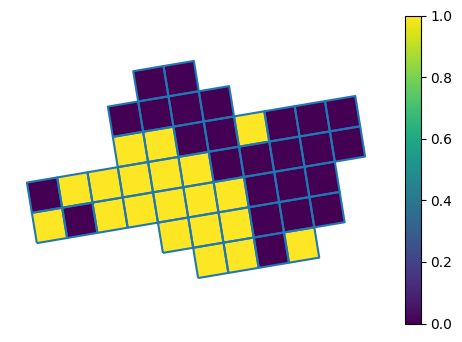

In [46]:
# Plot 
geo_1km["solution"] = solution_1km
geo_1km["solution"] = geo_1km["solution"].astype(int)
fig, ax = plt.subplots(figsize=(6, 4))
geo_1km.boundary.plot(ax=ax)
geo_1km.plot(column='solution', ax=ax, legend=True)
ax.set_axis_off()
plt.show()

# 200m

In [52]:
geo_200 = gpd.read_file("../data/processed/44055/200/gdf_city_with_dist.gpkg")
geo_200.head()

,id,population,density_km2,niveau_de_vie_moyen,demand_pop_kWh,demand_traffic_kWh,total_demand_kWh,concu_nb_pdc,vinci_nb_pdc,nb_pdc,...,dist_422,dist_423,dist_424,dist_425,dist_426,dist_427,dist_428,dist_429,dist_430,geometry
0,CRS3035RES200mN2761400E3391600,31.5,788.861822,29316.704762,1.051370,0.0,1.051370,0.0,0.0,0.0,...,4.689689,5.534841,5.436998,4.884685,4.848552,4.820473,5.018388,5.790279,5.750147,"POLYGON ((-2.3372 47.26715, -2.33762 47.26892,..."
1,CRS3035RES200mN2761400E3391800,26.0,651.123954,23425.138462,0.000000,0.0,0.000000,0.0,0.0,0.0,...,4.735559,5.638107,5.534847,4.928702,4.884691,4.848558,5.045333,5.882190,5.801296,"POLYGON ((-2.33459 47.26745, -2.33501 47.26922..."
2,CRS3035RES200mN2761400E3392000,2.0,50.086451,28876.200000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,4.789369,5.746497,5.638112,4.980388,4.928708,4.884698,5.080036,5.979397,5.858848,"POLYGON ((-2.33197 47.26774, -2.3324 47.26952,..."
3,CRS3035RES200mN2761600E3391200,93.5,2341.540973,24798.703743,11.284012,0.0,11.284012,0.0,0.0,0.0,...,4.425035,5.167523,5.078366,4.622676,4.601897,4.589769,4.788994,5.440463,5.471568,"POLYGON ((-2.34285 47.26832, -2.34327 47.27009..."
4,CRS3035RES200mN2761600E3391400,72.0,1803.111518,27235.497222,0.890049,0.0,0.890049,0.0,0.0,0.0,...,4.455699,5.262799,5.167529,4.651996,4.622682,4.601903,4.800585,5.523716,5.510797,"POLYGON ((-2.34023 47.26862, -2.34066 47.27039..."


In [53]:
# Parameters
locations = geo_200.index.to_list()

demands_kWh = geo_200["demand_pop_kWh"].to_list()
demands_pop = geo_200["population"].to_list()

prices_kWh = [0.25] * len(locations)
prices_pop = [20] * len(locations)

costs = [60000 / (365 * 15)] * len(locations)

station_capacity_kWh = 22 * 12 # 60kW * 8h
station_capacity_pop = 1e6 / geo_200["density_km2"].mean()

max_distance = 1
max_total_stations = 10
existing_stations = {i: 1 for i in [9,37,62,96,100,135,152,156,157,166,184,211,212,218,219,220,246,247,248,276,313]}

existing_station_capacity_kWh = 22 * 12
existing_station_capacity_pop = 1e6 / geo_200["density_km2"].mean()


max_stations_per_location = 10

# Adjacency matrix
adjacency = np.load("../data/processed/44055/200/adjacency_matrix.npy")

# Genetic parameters
population_size = 100
mutation_rate = 0.2
crossover_rate = 0.8
elite_size = 10
max_generations = 100

In [54]:
for simulation_type in ["kWh", "pop"]:
    for max_total_stations in [1, 5, 10, 20]:
        ga_200 = ChargingStationGA(
            locations,
            demands_pop if simulation_type == "pop" else demands_kWh,
            prices_pop if simulation_type == "pop" else prices_kWh,
            costs,
            max_distance,
            station_capacity_pop if simulation_type == "pop" else station_capacity_kWh,
            max_total_stations,
            existing_stations,
            existing_station_capacity_pop if simulation_type == "pop" else existing_station_capacity_kWh,
            max_stations_per_location,
            population_size,
            mutation_rate,
            crossover_rate,
            elite_size,
            max_generations,
            adjacency,
        )
        solution_200, stats_200 = ga_200.run()

        demand_unit = "pop" if simulation_type == "pop" else "kWh"

        # Enregistrement des résultats
        results = {
            "zone": "200m",
            "demand": demand_unit,
            "solution": solution_200.tolist(),
            "profit": stats_200["profit"],
            "demand_satisfaction": stats_200["demand_satisfaction"],
            "parameters": {
                "population_size": population_size,
                "mutation_rate": mutation_rate,
                "crossover_rate": crossover_rate,
                "elite_size": elite_size,
                "max_generations": max_generations,
                "max_distance": max_distance,
                "station_capacity_kWh": station_capacity_kWh,
                "station_capacity_pop": station_capacity_pop,
                "max_total_stations": max_total_stations,
                "max_stations_per_location": max_stations_per_location,
            },
        }
        total_demand_satisfied = sum(solution_200) * (station_capacity_kWh if simulation_type == "kWh" else station_capacity_pop)
        results["profit"] = total_demand_satisfied * (0.25 if simulation_type == "kWh" else 20) - 60000 / (365 * 15)

        # Enregistrement des résultats
        import json

        # Nom du fichier dépendant du type de simulation
        filename = f"results/200m/results_{results['zone']}_{simulation_type}_{results['parameters']['max_total_stations']}_{1 if existing_stations else 0}.json"

        # Sauvegarde dans un fichier JSON
        with open(filename, "w") as f:
            json.dump(results, f, indent=4)

Starting genetic algorithm optimization...
Station capacity: 264 kWh/day
Maximum total stations: 1
Generation 0: Fitness = 74.47, Profit: -4.95, Coverage: 79.43, Avg Satisfaction: 100.0%, Stations: 1


/Users/maximemoutet/Documents/Scolaire/M2DS/Capstone/capstone-vinci/model/GA.py:184: RuntimeWarning: divide by zero encountered in divide
  satisfaction_percentage = min(1.0, total_capacity / location_demand)


Generation 10: Fitness = 83.45, Profit: 3.94, Coverage: 79.52, Avg Satisfaction: 100.0%, Stations: 1
Generation 20: Fitness = 83.45, Profit: 3.94, Coverage: 79.52, Avg Satisfaction: 100.0%, Stations: 1
Generation 30: Fitness = 83.45, Profit: 3.94, Coverage: 79.52, Avg Satisfaction: 100.0%, Stations: 1
Generation 40: Fitness = 83.45, Profit: 3.94, Coverage: 79.52, Avg Satisfaction: 100.0%, Stations: 1
Generation 50: Fitness = 83.45, Profit: 3.94, Coverage: 79.52, Avg Satisfaction: 100.0%, Stations: 1
Generation 60: Fitness = 83.45, Profit: 3.94, Coverage: 79.52, Avg Satisfaction: 100.0%, Stations: 1
Generation 70: Fitness = 83.45, Profit: 3.94, Coverage: 79.52, Avg Satisfaction: 100.0%, Stations: 1
Generation 80: Fitness = 83.45, Profit: 3.94, Coverage: 79.52, Avg Satisfaction: 100.0%, Stations: 1
Generation 90: Fitness = 83.45, Profit: 3.94, Coverage: 79.52, Avg Satisfaction: 100.0%, Stations: 1

Optimization complete after 100 generations
Best solution fitness: 83.45
Best profit: 3.94

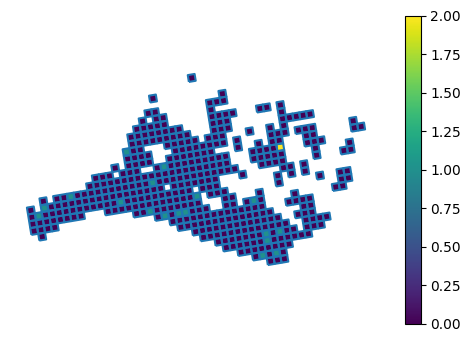

In [55]:
# Plot
geo_200["solution"] = solution_200
geo_200["solution"] = geo_200["solution"].astype(int)
fig, ax = plt.subplots(figsize=(6, 4))
geo_200.boundary.plot(ax=ax)
geo_200.plot(column='solution', ax=ax, legend=True, cmap='viridis')
ax.set_axis_off()
plt.show()

In [56]:
import folium
from folium import features
import geopandas as gpd
from shapely.geometry import LineString
import branca.colormap as cm

import os, sys

# Get the absolute path of the utils.py directory
utils_path = os.path.abspath("../demand_estimation/")
sys.path.append(utils_path)

from utils_data import get_contours_city_ign

def viz_map_stations(zone: str, solution: list, D: float, alpha: float=1.0):
    code_insee = 44055
    file_ign = '../data/Data/BDCARTO/44_Loise_Atlantique/data.gpkg'

    gdf_contours_city, geometry_contours_city = get_contours_city_ign(file_ign, code_insee)
    center_lon, center_lat = geometry_contours_city.centroid.coords[0]
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    input_file = f"../data/processed/44055/{zone}/gdf_city_with_dist.gpkg"
    gdf_input = gpd.read_file(input_file)

    colormap = cm.linear.YlOrRd_09.scale(gdf_input['total_demand_kWh'].min(), gdf_input['total_demand_kWh'].max())
    colormap.caption = 'Demand kWh'


    # Add the GeoJson layer with tooltips
    folium.GeoJson(
        gdf_contours_city,
        name="La Baule",
        style_function=lambda x: {"color": "black", "weight": 2, "fillOpacity": 0.1},
    ).add_to(m)


    # Add the grid layer to the map with color based on total_demand column
    folium.GeoJson(
        gdf_input,
        name="Grid",
        style_function=lambda feature: {
            'fillColor': colormap(feature['properties']['total_demand_kWh']),
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6,
        }
    ).add_to(m)

    # Iterate through each row in the GeoDataFrame and plot each feature
    for i, row in gdf_input.iterrows():
        # Extract geometry and properties for each feature
        feature = row['geometry']
        demand = row['total_demand_kWh']  # Assuming this column exists
    
        # Create a popup displaying the number of people
        text = f"Total demand={demand:.2f}kWh"
        popup = folium.Popup(text, max_width=300)
        
        # Style each feature based on the number of people
        folium.GeoJson(
            feature,
            name=f"Carreau {row.name}",
            popup=popup,
            style_function=lambda x, demand=demand: {
                    'fillColor': colormap(demand),  # Color based on the number of people
                    'color': 'black',  # Border color
                    'weight': 2,  # Border width
                    'fillOpacity': 0.7  # Fill opacity
                }
        ).add_to(m)
        
        # If solution[i] > 0, add a marker at the centroid of the feature
        if solution[i] > 0:

            centroid = feature.centroid  # Get centroid of the area
            marker_popup = folium.Popup(f"Num stations: {solution[i]}", max_width=300)
            
            # Change color based on the number of stations
            if solution[i] == 1:
                color = "green"
            elif solution[i] == 2:
                color = "orange"
            else:
                color = "red"
            
            # Add a marker at the centroid of the feature
            folium.Marker(
                location=[centroid.y, centroid.x],
                popup=marker_popup,
                icon=folium.Icon(color=color)
            ).add_to(m)

            # Compute buffer size
            buffer_radius = alpha * D * 1000  # Adjust based on your needs
            
            # Add circular buffer
            folium.Circle(
                location=[centroid.y, centroid.x],
                radius=buffer_radius,  # Radius in meters
                color=color,
                # Opacity of border
                opacity=0.3,
                fill=True,
                fill_color=color,
                fill_opacity=0.2
            ).add_to(m)

    # Add the color map to the map
    colormap.add_to(m)

    # Add a layer control
    folium.LayerControl().add_to(m)

    return m

# Visualisations

In [57]:
# Results IRIS
import os

folder_path = "results/iris/"

for file in os.listdir(folder_path):
    if file.endswith(".json"):
        with open(folder_path + file) as f:
            data = json.load(f)
            print(f"Zone: {data['zone']}")
            print(f"Demand: {data['demand']}")
            print(f"Max stations: {data['parameters']['max_total_stations']}")
            print(f"Solution: {data['solution']}")
            print(f"Profit: {data['profit']:.2f}")
            print(f"Demand satisfaction: {data['demand_satisfaction']:.2f}")
            print("\n")


            # Display
            m = viz_map_stations(data['zone'], data['solution'], 2)
            m.save(f"results/iris/{data['zone']}_{data['demand']}_{data['parameters']['max_total_stations']}.html")

Zone: iris
Demand: kWh
Max stations: 5
Solution: [1, 1, 1, 0, 1, 1]
Profit: 319.04
Demand satisfaction: 70.42


Zone: iris
Demand: pop
Max stations: 5
Solution: [1, 1, 0, 1, 1, 1]
Profit: 103838.83
Demand satisfaction: 32.01


Zone: iris
Demand: kWh
Max stations: 1
Solution: [0, 0, 1, 0, 0, 0]
Profit: 55.04
Demand satisfaction: 14.58


Zone: iris
Demand: pop
Max stations: 20
Solution: [3, 2, 2, 3, 4, 5]
Profit: 394618.23
Demand satisfaction: 100.00


Zone: iris
Demand: kWh
Max stations: 10
Solution: [2, 2, 2, 1, 1, 1]
Profit: 583.04
Demand satisfaction: 98.95


Zone: iris
Demand: pop
Max stations: 1
Solution: [0, 0, 0, 0, 0, 1]
Profit: 20759.00
Demand satisfaction: 6.40


Zone: iris
Demand: pop
Max stations: 10
Solution: [2, 1, 1, 2, 1, 3]
Profit: 207688.61
Demand satisfaction: 64.03


Zone: iris
Demand: kWh
Max stations: 20
Solution: [2, 2, 2, 1, 1, 1]
Profit: 583.04
Demand satisfaction: 98.95




In [58]:
# Results IRIS
import os

folder_path = "results/200m/"

for file in os.listdir(folder_path):
    if file.endswith(".json"):
        with open(folder_path + file) as f:
            data = json.load(f)
            print(f"Zone: {data['zone']}")
            print(f"Demand: {data['demand']}")
            print(f"Max stations: {data['parameters']['max_total_stations']}")
            print(f"Number of stations: {sum(data['solution'])}")

            print(f"Number of stations: {len(data['solution'])}")
            print(f"Solution: {data['solution']}")
            print(f"Profit: {data['profit']:.2f}")
            print(f"Demand satisfaction: {data['demand_satisfaction']:.2f}")
            print("\n")

            # Display
            m = viz_map_stations(data['zone'][:-1], data['solution'], 2)
            m.save(f"results/200m/{data['zone']}_{data['demand']}_{data['parameters']['max_total_stations']}.html")


Zone: 200m
Demand: kWh
Max stations: 5
Number of stations: 5
Number of stations: 431
Solution: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [59]:
# Results IRIS
import os

folder_path = "results/1km/"

for file in os.listdir(folder_path):
    if file.endswith(".json"):
        with open(folder_path + file) as f:
            data = json.load(f)
            print(f"Zone: {data['zone']}")
            print(f"Demand: {data['demand']}")
            print(f"Max stations: {data['parameters']['max_total_stations']}")
            print(f"Number of stations: {sum(data['solution'])}")

            print(f"Number of stations: {len(data['solution'])}")
            print(f"Solution: {data['solution']}")
            print(f"Profit: {data['profit']:.2f}")
            print(f"Demand satisfaction: {data['demand_satisfaction']:.2f}")
            print("\n")

            # Display
            m = viz_map_stations(data['zone'], data['solution'], 1)
            m.save(f"results/1km/{data['zone']}_{data['demand']}_{data['parameters']['max_total_stations']}.html")


Zone: 1km
Demand: kWh
Max stations: 1
Number of stations: 1
Number of stations: 45
Solution: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Profit: 55.04
Demand satisfaction: 13.29


Zone: 1km
Demand: pop
Max stations: 1
Number of stations: 1
Number of stations: 45
Solution: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Profit: 39966.50
Demand satisfaction: 8.89


Zone: 1km
Demand: pop
Max stations: 20
Number of stations: 20
Number of stations: 45
Solution: [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Profit: 799538.13
Demand satisfaction: 82.35


Zone: 1km
Demand: kWh
Max stations: 10
Number of stations: 10
Number of stations: 45
Solution: [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,